In [1]:
import os

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from ase.build import bulk
from ase.io import write

In [4]:
from adis_tools.parsers import parse_pw

# Functions

In [5]:
def write_input(input_dict, working_directory="."):
    filename = os.path.join(working_directory, 'input.pwi')
    os.makedirs(working_directory, exist_ok=True)
    write(
        filename=filename, 
        images=input_dict["structure"], 
        Crystal=True, 
        kpts=input_dict["kpts"], 
        input_data={
            'CONTROL': {
                'calculation': input_dict["calculation"],
            },
            'SYSTEM': {
                'occupations': 'smearing',
                'degauss': input_dict["smearing"],
            }
        }, 
        pseudopotentials=input_dict["pseudopotentials"],
        tstress=True, 
        tprnfor=True
    )

In [6]:
def collect_output(working_directory="."):
    output = parse_pw(os.path.join(working_directory, 'pwscf.xml'))
    return {
        "structure": output['ase_structure'],
        "energy": output["energy"],
        "volume": output['ase_structure'].get_volume(),
    }

In [7]:
def workflow(project, structure, pseudopotentials): 
    # Structure optimization 
    job_qe_minimize = pr.wrap_executable(
        job_name="job_qe_minimize",
        write_input_funct=write_input,
        collect_output_funct=collect_output,
        input_dict={
            "structure": structure, 
            "pseudopotentials": pseudopotentials, 
            "kpts": (3, 3, 3),
            "calculation": "vc-relax",
            "smearing": 0.02,
        },
        executable_str="mpirun -np 1 pw.x -in input.pwi > output.pwo",
        execute_job=True,
    )
    structure_opt = job_qe_minimize.output.structure

    # Energy Volume Curve 
    energy_lst, volume_lst = [], []
    for i, strain in enumerate(np.linspace(0.9, 1.1, 5)):
        structure_strain = structure_opt.copy()
        structure_strain = structure.copy()
        structure_strain.set_cell(
            structure_strain.cell * strain**(1/3), 
            scale_atoms=True
        )
        job_strain = pr.wrap_executable(
            job_name="job_strain_" + str(i),
            write_input_funct=write_input,
            collect_output_funct=collect_output,
            input_dict={
                "structure": structure_strain, 
                "pseudopotentials": pseudopotentials, 
                "kpts": (3, 3, 3),
                "calculation": "scf",
                "smearing": 0.02,
            },
            executable_str="mpirun -np 1 pw.x -in input.pwi > output.pwo",
            execute_job=True,
        )
        energy_lst.append(job_strain.output.energy)
        volume_lst.append(job_strain.output.volume)
    
    return {"volume": volume_lst, "energy": energy_lst}

# Setup

In [8]:
from pyiron_base import Project

In [9]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

# Workflow

In [10]:
job_workflow = pr.wrap_python_function(workflow)
job_workflow.input.project = pr
job_workflow.input.structure = bulk('Al', a=4.05, cubic=True)
job_workflow.input.pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}
job_workflow.run()

The job workflow315b06480a88d99b06c8032eedfb8880 was saved and received the ID: 1
The job job_qe_minimize was saved and received the ID: 2
The job job_strain_0 was saved and received the ID: 3
The job job_strain_1 was saved and received the ID: 4
The job job_strain_2 was saved and received the ID: 5
The job job_strain_3 was saved and received the ID: 6
The job job_strain_4 was saved and received the ID: 7


# Result

Text(0, 0.5, 'Energy')

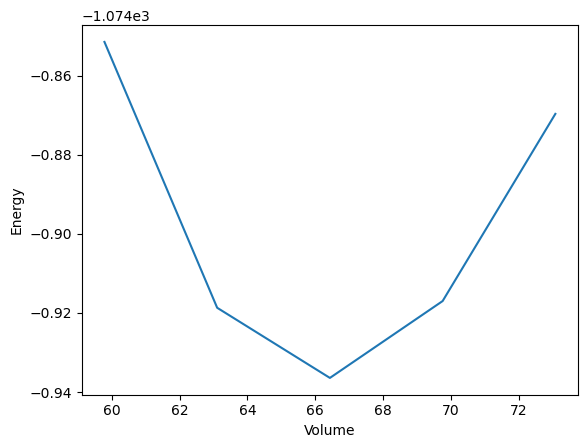

In [11]:
plt.plot(job_workflow.output.result["volume"], job_workflow.output.result["energy"])
plt.xlabel("Volume")
plt.ylabel("Energy")

# Summary

In [12]:
pr.job_table()

id    status chemicalformula                                       job  \
0   1  finished            None  workflow315b06480a88d99b06c8032eedfb8880   
1   2  finished            None                           job_qe_minimize   
2   3  finished            None                              job_strain_0   
3   4  finished            None                              job_strain_1   
4   5  finished            None                              job_strain_2   
5   6  finished            None                              job_strain_3   
6   7  finished            None                              job_strain_4   

                                      subjob projectpath             project  \
0  /workflow315b06480a88d99b06c8032eedfb8880        None  /home/jovyan/test/   
1                           /job_qe_minimize        None  /home/jovyan/test/   
2                              /job_strain_0        None  /home/jovyan/test/   
3                              /job_strain_1        None  /home/jovyan/test/   
4                              /job_strain_2        None  /home/jovyan/test/   
5                              /job_strain_3        None  /home/jovyan/test/   
6                              /job_strain_4        None  /home/jovyan/test/   

                   timestart                   timestop  totalcputime  \
0 2024-03-21 01:55:04.298411                        NaT           NaN   
1 2024-03-21 01:55:04.375121 2024-03-21 01:55:49.564039          45.0   
2 2024-03-21 01:55:49.624729 2024-03-21 01:55:58.575506           8.0   
3 2024-03-21 01:55:58.633615 2024-03-21 01:56:08.626185           9.0   
4 2024-03-21 01:56:08.685117 2024-03-21 01:56:19.151949          10.0   
5 2024-03-21 01:56:19.212804 2024-03-21 01:56:29.531875          10.0   
6 2024-03-21 01:56:29.594373 2024-03-21 01:56:40.025759          10.0   

                                                                computer  \
0  pyiron@jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2duqeziubh#1   
1  pyiron@jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2duqeziubh#1   
2  pyiron@jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2duqeziubh#1   
3  pyiron@jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2duqeziubh#1   
4  pyiron@jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2duqeziubh#1   
5  pyiron@jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2duqeziubh#1   
6  pyiron@jupyter-jan-2djanssen-2dqua-2dsso-5fpyiron-5fbase-2duqeziubh#1   

                     hamilton hamversion parentid masterid  
0  PythonFunctionContainerJob        0.4     None     None  
1      ExecutableContainerJob        0.4     None     None  
2      ExecutableContainerJob        0.4     None     None  
3      ExecutableContainerJob        0.4     None     None  
4      ExecutableContainerJob        0.4     None     None  
5      ExecutableContainerJob        0.4     None     None  
6      ExecutableContainerJob        0.4     None     None